# Instancia de librarias

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from datetime import datetime # Trabajar con fechas

# Metricas de desempeño de modelos 
import scipy.stats as stats
import statistics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Series de tiempo
# from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
# from statsmodels.tsa.stattools import adfuller # prueba 
# from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
# import pmdarima as pm # autoarima
# import statsmodels.formula.api as smf

# Prophet

# !pip3 install more-itertools --user
# !pip install prophet --user
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# Tamaño del cuadro de las gráficas por defult
plt.rcParams["figure.figsize"] = (12,6)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Setup complete")

Setup complete


# Importación de datos

In [2]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [3]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
wall_data.info()
wall_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11


#### Frecuencia de tiempo

In [4]:
# Semanal
stores = wall_data
stores = stores.iloc[:,[1,0,2]]
stores['Store'] = stores.Store.astype(str)
stores.columns = ['Date','Store','Weekly_Sales']

In [5]:
num_store = stores['Store'].unique()
num_store

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'],
      dtype=object)

In [6]:
mes = {}
for store in num_store:
    df = stores[stores['Store']==store].copy()
    df.drop('Store',axis=1, inplace=True)
    mes[store] = df
    df.columns = ['ds','y']
    df.rename_axis(index=None,columns=None)
   
# Elegir una tienda    
# mes['20']

#### Performance

In [7]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);

# def cross_validation(model,a,b):
#     cv = cross_val_score(model,a,b,cv=10,scoring='r2')
#     print(f'Cross validation: {cv.mean()*100}%')

#### Conjunto de entrenamiento y test

In [8]:
def tra_tes(st,period):
    train = st.sort_values('ds')[:len(st)-period]  # primero datos
    test = st.sort_values('ds')[len(st)-period:]   # últimos datos 
    return train,test

# tra_tes(dataframe,period='num_Semanas')

## Mensual

In [9]:
m_20 =  mes['20']
m_14 =  mes['14'] # No son datos estacionarios
m_5 =  mes['5']

## Prophet

In [10]:
m_20.head()

,ds,y
2717,2010-02-05,"2,401,395.47"
2718,2010-02-12,"2,109,107.90"
2719,2010-02-19,"2,161,549.76"
2720,2010-02-26,"1,898,193.95"
2721,2010-03-05,"2,119,213.72"


#### Con Entrenamiento y Test

In [11]:
# tra_tes(dataframe,period='num_Semanas')
pr = 12
train, test = tra_tes(m_20,pr)
# train, test = tra_tes(m_14,12)
# train, test = tra_tes(m_5,12)

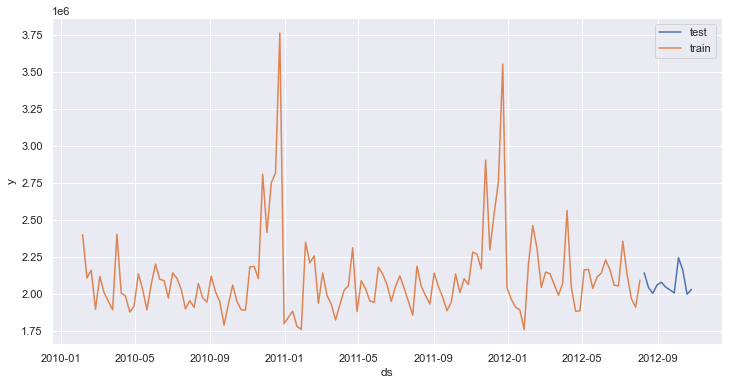

In [12]:
sns.lineplot(data=test, x = 'ds',y ='y', label='test');
sns.lineplot(data=train, x = 'ds',y ='y', label='train');

##### Intanciar al modelo y entrenarlo

In [13]:
# quitar entrenamiento y test de la sigueinte línea
train, test = tra_tes(m_20,12)
iw=0.95
cps = 0.0001
ys= 22
m = Prophet(interval_width=iw, changepoint_prior_scale=cps, yearly_seasonality=ys)

# Pasandole test o train
m.fit(train)
# m.fit(test)

20:14:01 - cmdstanpy - INFO - Chain [1] start processing
20:14:01 - cmdstanpy - INFO - Chain [1] done processing
20:14:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
20:14:01 - cmdstanpy - INFO - Chain [1] start processing
20:14:01 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Construir futuro
# pr = 12
fr = 'W-FRI'
future = m.make_future_dataframe(periods=pr, freq=fr)

# Hacer predicciones
pp = m.predict(future)
pp.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
138,2012-09-28,"2,174,645.74","1,748,646.35","2,193,918.59","2,174,645.74","2,174,645.75","-207,793.77","-207,793.77","-207,793.77","-207,793.77","-207,793.77","-207,793.77",0.00,0.00,0.00,"1,966,851.98"
139,2012-10-05,"2,175,389.24","1,908,952.24","2,360,126.08","2,175,389.23","2,175,389.24","-45,958.44","-45,958.44","-45,958.44","-45,958.44","-45,958.44","-45,958.44",0.00,0.00,0.00,"2,129,430.79"
140,2012-10-12,"2,176,132.73","1,842,272.17","2,294,002.20","2,176,132.73","2,176,132.74","-106,948.07","-106,948.07","-106,948.07","-106,948.07","-106,948.07","-106,948.07",0.00,0.00,0.00,"2,069,184.66"
141,2012-10-19,"2,176,876.23","1,850,765.71","2,311,284.93","2,176,876.22","2,176,876.24","-100,025.84","-100,025.84","-100,025.84","-100,025.84","-100,025.84","-100,025.84",0.00,0.00,0.00,"2,076,850.39"
142,2012-10-26,"2,177,619.72","1,755,902.45","2,217,031.09","2,177,619.71","2,177,619.73","-194,545.38","-194,545.38","-194,545.38","-194,545.38","-194,545.38","-194,545.38",0.00,0.00,0.00,"1,983,074.34"


In [15]:
# plot = m.plot(pp)

In [16]:
# plot2 = m.plot_components(pp)

In [17]:
pp = pd.DataFrame({'Date':pp[-pr:]['ds'],'Pred':pp[-pr:]['yhat']})
pp.head()

,Date,Pred
131,2012-08-10,"2,158,082.26"
132,2012-08-17,"2,047,951.42"
133,2012-08-24,"1,986,018.35"
134,2012-08-31,"2,163,612.81"
135,2012-09-07,"2,108,118.66"


In [18]:
train.columns = ['Date','Pred']
test.columns = ['Date','Pred']

x_train = train.Date
y_train  = train.Pred
x_test = test.Date
y_test  = test.Pred
x_pp = pp.Date
y_pp = pp.Pred


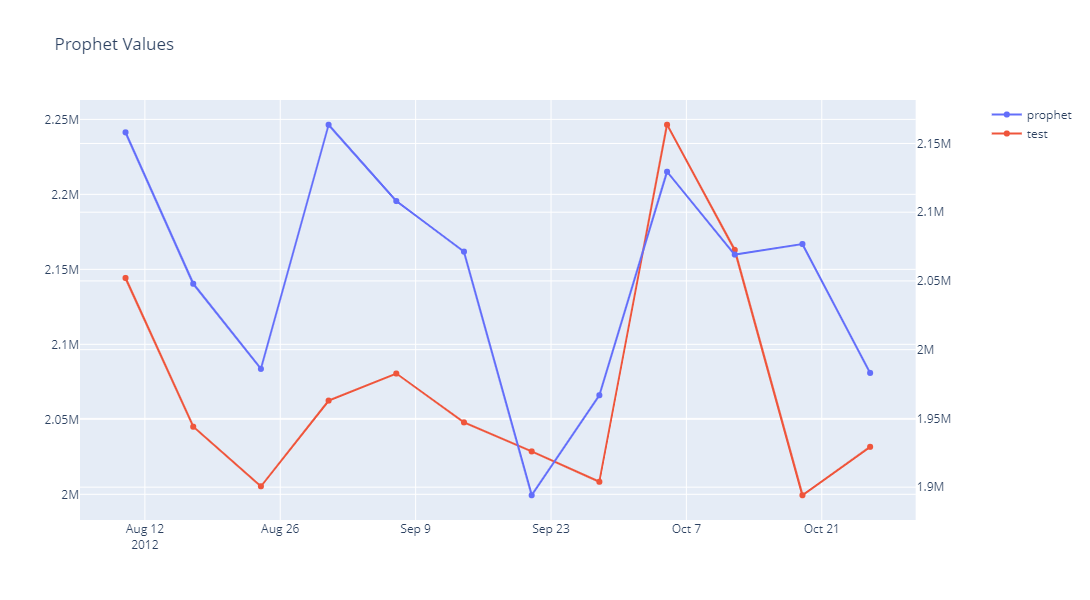

In [29]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x = x_test,y = y_test, name="test"),
    secondary_y=False
)


fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()

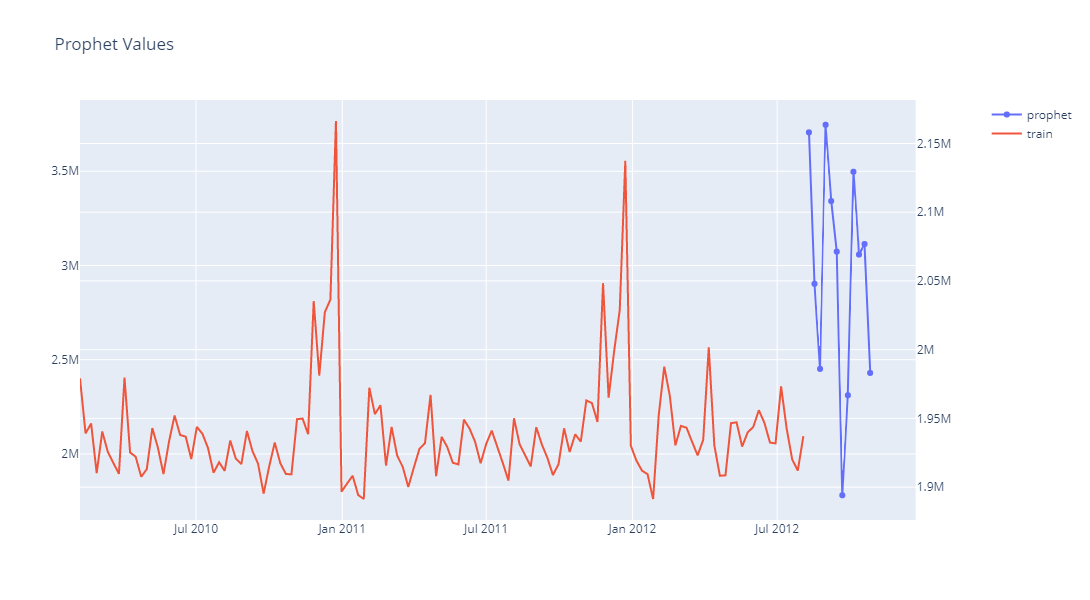

In [24]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x = x_train,y = y_train, name="train"),
    secondary_y=False
)

fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()

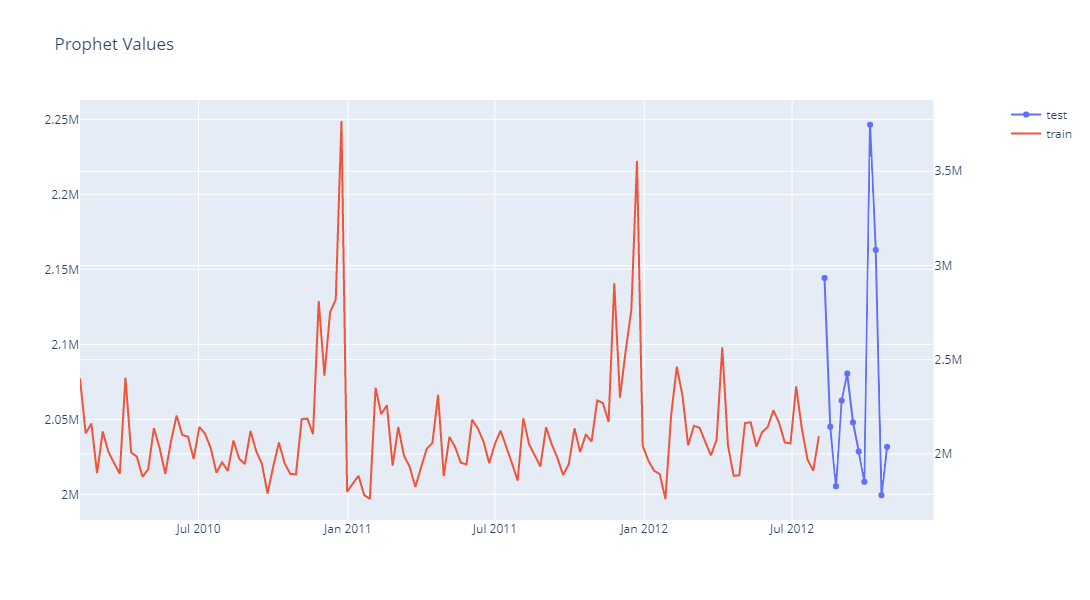

In [30]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = x_test,y = y_test, name="test"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = x_train,y = y_train, name="train"),
    secondary_y=True
)

fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()


Accuracy test(R2):  -0.1543606457791391
Mean Absolute Error:  58412.06397248271
Mean Square Error:  5229879271.24549
Root Mean Square Error:  72317.90422326612
Mean Absolute Percentage Error:  0.028021836323798035


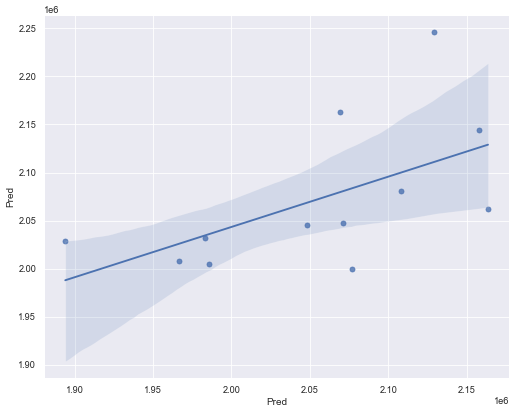

In [27]:
print('Accuracy test(R2): ', metrics.r2_score(test.Pred,pp.Pred)*100)
performance(test.Pred,pp.Pred)